In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from random import Random
from sklearn.model_selection import KFold, cross_val_predict
# from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline, BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
# from sklearn.decomposition import PCA
# from scipy.stats import percentileofscore
from scipy.stats import hmean

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [148]:
train = pd.read_csv('../input/train.csv')

In [95]:
def load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    
    y = np.log(train['SalePrice'].values)
    ids_submission = test['Id'].values
    
    combined = train.append(test, ignore_index=True).drop(['Id','SalePrice'], axis=1)
    
-
                
    combined = combined.select_dtypes(exclude=['category'])
    
    combined.fillna(-99, inplace=True)
    
    #combined = combined.values
    
    X = combined.iloc[:train.shape[0],:]
    X_submission = combined.iloc[train.shape[0]:,:]
        
    return y, X, X_submission, ids_submission   

y, X, X_submission, ids_submission = load_data()

In [96]:
class ProcessData(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        for c in X.columns:
            if X[c].dtype.name == 'category':
                if X[c].cat.ordered:
                    X[c] = X[c].cat.codes
                    
        return pd.get_dummies(X).values

In [97]:
process_data = ProcessData()

In [98]:
model = make_pipeline(ProcessData(), 
                      Imputer(),
                      RandomForestRegressor(n_estimators=100, n_jobs=4))

In [99]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model = RandomForestRegressor(n_estimators=100, n_jobs=4)

sfs1 = SFS(model,
          k_features=8,
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',
          cv=2)

sfs1 = sfs1.fit(X.values,y)

Features: 8/8

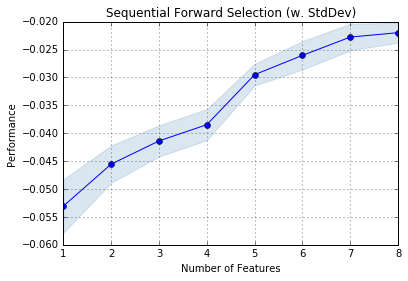

In [100]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [107]:
import seaborn as sns

In [162]:
train['ln_SalePrice'] = np.log(train['SalePrice'])

In [113]:
from scipy.stats import skew, boxcox

In [122]:
bc_grlivarea, lambda_grlivarea = boxcox(train.GrLivArea)

In [123]:
boxcox(train.GrLivArea, lambda_grlivarea)

array([ 7.62171261,  7.30362313,  7.66729361, ...,  7.95076794,
        7.13885791,  7.29863806])

In [124]:
bc_grlivarea

array([ 7.62171261,  7.30362313,  7.66729361, ...,  7.95076794,
        7.13885791,  7.29863806])

In [149]:
train['YearBuilt_adj'], _ = boxcox(train.YearBuilt)

In [150]:
train['YearRemodAdd_adj'], _ = boxcox(train.YearRemodAdd)

In [159]:
train.YearRemodAdd.describe()

count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

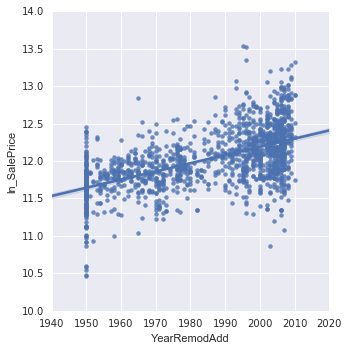

In [163]:
sns.lmplot('YearRemodAdd', 'ln_SalePrice', train)

In [165]:
train['RemodAge'] = train.YrSold - train.YearRemodAdd
train['HouseAge'] = train.YrSold - train.YearBuilt

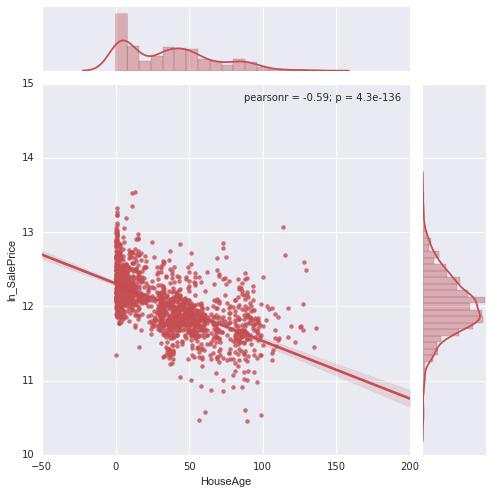

In [167]:
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

tips = sns.load_dataset("tips")
g = sns.jointplot("HouseAge", "ln_SalePrice", data=train, kind="reg", 
                  ylim=(10,15),
                  color="r", size=7)

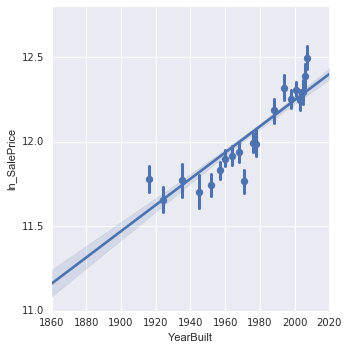

In [127]:
sns.lmplot('YearBuilt', 'ln_SalePrice', train, x_bins=20)

In [105]:
X.columns[list(sfs1.k_feature_idx_)]

Index([u'YearBuilt', u'OverallCond', u'BsmtFinSF1', u'TotalBsmtSF',
       u'Fireplaces', u'OverallQual', u'GarageCars', u'GrLivArea'],
      dtype='object')

In [101]:
sfs1.k_feature_idx_

(33, 26, 4, 31, 10, 27, 13, 15)

In [58]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

boston = load_boston()
X, y = boston.data, boston.target

Features: 13/13

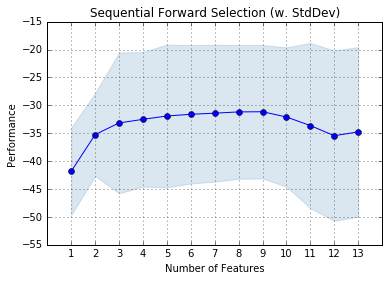

In [56]:


lr = LinearRegression()

sfs = SFS(lr, 
          k_features=13, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=0)
sfs1 = sfs1.fit(X, y)

In [703]:
model = make_pipeline(ProcessData(),
                      Imputer(strategy='most_frequent'),
                      GradientBoostingRegressor(random_state=1773,
                                                learning_rate=0.1,
                                                max_depth=4,
                                                max_features=0.7,
                                                min_samples_leaf=1,
                                                n_estimators=250,
                                                subsample=0.75))

In [704]:
def get_oof_preds(model, X, y, X_sub, n_folds=10, n_iter=1, seed=1234):
    preds = np.zeros((np.shape(X)[0], n_iter))
    preds_sub = np.zeros((np.shape(X_sub)[0], n_iter))
    rng = Random(seed)
    for i in range(n_iter):
        rs = rng.randint(1,9999)
        folds = KFold(n_folds, shuffle=True, random_state=rs)
        preds_sub_j = np.zeros((np.shape(X_sub)[0], n_folds))
        print 'iter: {}'.format(i)
        for j, (train_index, test_index) in enumerate(folds.split(X)):
            X_train = X.iloc[train_index, :]
            X_test = X.iloc[test_index, :]
            y_train = y[train_index]
            model.fit(X_train, y_train)
            preds[test_index, i] = model.predict(X_test)
            preds_sub_j[:,j] = model.predict(X_sub)
        preds_sub[:, i] = hmean(preds_sub_j, axis=1)
    return preds, preds_sub

In [706]:
%%time
oof_preds, bld_preds_sub = get_oof_preds(model, X, y, X_submission, n_folds=20, n_iter=20, seed=1337)

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
CPU times: user 12min 56s, sys: 1.51 s, total: 12min 58s
Wall time: 12min 58s


In [683]:
%matplotlib inline
import matplotlib.pyplot as plt

In [708]:
cv_scores = np.apply_along_axis(lambda x: rmse(y, x), axis=0, arr=oof_preds)
print 'score:', hmean(cv_scores), np.std(cv_scores)

score: 0.124096394024 0.00216032764525


In [710]:
bld_preds_sub_hmean = hmean(bld_preds_sub, axis=1)
bld_preds_sub_std = np.std(bld_preds_sub, axis=1)

In [711]:
print 'submission'
print 'std (max):', np.max(bld_preds_sub_std)

submission
std (max): 0.0254741396425


In [712]:
oof_preds_hmean = hmean(oof_preds, axis=1)
oof_preds_std = np.std(oof_preds, axis=1)

In [714]:
np.max(oof_preds_std)

0.19015253709481195

In [685]:
#0.118766769276

In [715]:
print 'rmse:', rmse(y, oof_preds_hmean)

rmse: 0.118766769276


In [719]:
max_error_index = np.argmax(np.abs(y - oof_preds_hmean))
print (y - oof_preds_hmean)[max_error_index]
print X['Id'][max_error_index]

-1.14187386892
524


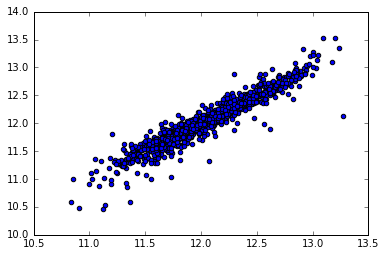

In [718]:
plt.scatter(x=oof_preds_hmean, y=y);

In [729]:
pd.DataFrame({'Id': ids_submission, 'SalePrice': np.exp(bld_preds_sub_hmean)})\
  .to_csv('../ensemble/models/bld_gbm_sub.csv', index=False)

In [727]:
model_output = {'train': list(oof_preds_hmean), 'test': list(bld_preds_sub_hmean)}

In [728]:
import json
with open('../ensemble/models/bld_gbm.json', 'w') as outfile:
    json.dump(model_output, outfile)